<a href="https://colab.research.google.com/github/devyaniiiiii/Machine_learning_CA_2/blob/main/FakeNews_India_Colab_(2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 📰 Fake News Detection for Indian News (NLP Project)

This Colab notebook trains ML + DL models (Logistic Regression, SVM, LSTM)
to classify Indian news as **Fake / Real**.



In [4]:
# ✅ Setup
from google.colab import drive
drive.mount('/content/drive')
!pip install nltk tensorflow --quiet
import nltk
nltk.download('stopwords')

Mounted at /content/drive


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [5]:
# ✅ Imports
import pandas as pd, numpy as np, re, html
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

In [10]:
# ✅ Load Dataset
path = '/content/IFND.csv'  # change if needed
df = pd.read_csv(path)
df.head()

,id,Statement,Image,Web,Category,Date,Label
0,2,"WHO praises India's Aarogya Setu app, says it ...",https://cdn.dnaindia.com/sites/default/files/s...,DNAINDIA,COVID-19,Oct-20,TRUE
1,3,"In Delhi, Deputy US Secretary of State Stephen...",https://cdn.dnaindia.com/sites/default/files/s...,DNAINDIA,VIOLENCE,Oct-20,TRUE
2,4,LAC tensions: China's strategy behind delibera...,https://cdn.dnaindia.com/sites/default/files/s...,DNAINDIA,TERROR,Oct-20,TRUE
3,5,India has signed 250 documents on Space cooper...,https://cdn.dnaindia.com/sites/default/files/s...,DNAINDIA,COVID-19,Oct-20,TRUE
4,6,Tamil Nadu chief minister's mother passes away...,https://cdn.dnaindia.com/sites/default/files/s...,DNAINDIA,ELECTION,Oct-20,TRUE


In [47]:
# ✅ Clean Text
def clean(s):
    s = str(s).lower()
    s = html.unescape(s)
    s = re.sub(r'http\S+', '', s)
    s = re.sub(r'[^a-z0-9 ]', ' ', s)
    s = re.sub(r'\s+', ' ', s).strip()
    return s

# Apply cleaning to the 'Eng_Trans_Statement' column
df['text_clean'] = df['Eng_Trans_Statement'].apply(clean)
df['text_stop'] = df['text_clean'].apply(lambda x: ' '.join([w for w in x.split() if w not in STOPWORDS]))

# Map the 'Label' column (assuming 'True'/'False' or similar boolean representation)
# Based on df.head(), the labels are 'False' and 'True' (boolean type)
# We need to convert them to 0 and 1
df['Label'] = df['Label'].astype(int)

df = df.dropna().reset_index(drop=True)
display(df.head())

,id,Author_Name,Fact_Check_Source,Source_Type,Statement,Eng_Trans_Statement,News Body,Eng_Trans_News_Body,Media_Link,Publish_Date,...,News_Category,Language,Region,Platform,Text,Video,Image,Label,text_clean,text_stop
0,BFNK_1,Shinjinee Majumder,Alt News,IFCN,à¥à¥à¤à¥à¤-à¤à¥à¤: à¤¤à¥à¤²à¤à¤à¤¾à...,Fact-check: A reporter in Telangana stopped sp...,à¤¸à¥à¤¶à¤² à¤®à¥à¤¡à¤¿à¤¯à¤¾ à¤ªà¤° à¤à¤ ...,A video is viral on social media in which a jo...,https://i0.wp.com/www.altnews.in/Hindi/wp-cont...,9th July 2022,...,Politics,Hindi,Telangana,Twitter,no,yes,no,0,fact check a reporter in telangana stopped spe...,fact check reporter telangana stopped speaking...
1,BFNK_2,Kalim Ahmed,Alt News,IFCN,PM à¤®à¥à¤¦à¥ à¤à¥ UAE à¤à¤¾ à¤¸à¤°à¥à¤µ...,Share by stating the old video of PM Modi's hi...,à¤ªà¥à¤°à¤§à¤¾à¤¨à¤®à¤à¤¤à¥à¤°à¥ à¤¨à¤°à¥...,A video of Prime Minister Narendra Modi being ...,https://i0.wp.com/www.altnews.in/Hindi/wp-cont...,9th July 2022,...,Politics,Hindi,National,Twitter,no,yes,no,0,share by stating the old video of pm modi s hi...,share stating old video pm modi highest civili...
2,BFNK_3,Abhishek Kumar,Alt News,IFCN,à¤µà¤¾à¤¯à¤°à¤² à¤¤à¤¸à¥à¤µà¥à¤° à¤®à¥à¤ à...,Supreme Court judges Suryakant and JB Pardiwal...,à¤¬à¥à¤¤à¥ à¤¦à¤¿à¤¨à¥à¤ à¤¨à¥à¤ªà¥à¤° à...,"Recently, Nupur Sharma made an objectionable c...",https://i0.wp.com/www.altnews.in/Hindi/wp-cont...,7th July 2022,...,Politics,Hindi,National,Twitter,no,no,yes,0,supreme court judges suryakant and jb pardiwal...,supreme court judges suryakant jb pardiwala vi...
3,BFNK_4,Abhishek Kumar,Alt News,IFCN,à¤®à¥à¤¡à¤¿à¤¯à¤¾ à¤¨à¥ à¤¦à¥ à¥à¤²à¤¤ à¥...,Media gave wrong news: After the victory of Mu...,à¤à¤ à¤µà¥à¤¡à¤¿à¤¯à¥ à¤¸à¥à¤¶à¤² à¤®à¥à...,A video is viral on social media. While sharin...,https://i0.wp.com/www.altnews.in/Hindi/wp-cont...,5th July 2022,...,Politics,Hindi,Madhya Pradesh,Twitter,no,no,yes,0,media gave wrong news after the victory of mus...,media gave wrong news victory muslim sarpanch ...
4,BFNK_5,Kinjal,Alt News,IFCN,à¤®à¤¹à¤¿à¤²à¤¾ à¤¨à¥ à¤°à¤¾à¤¹à¥à¤² à¤à¤¾à...,The woman lashed out at Rahul Gandhi to oppose...,à¤¸à¥à¤¶à¤² à¤®à¥à¤¡à¤¿à¤¯à¤¾ à¤ªà¤° à¤°à¤¾à...,A video of Rahul Gandhi has gone viral on soci...,https://i0.wp.com/www.altnews.in/Hindi/wp-cont...,4th July 2022,...,Politics,Hindi,Kashmir,Twitter,no,yes,no,1,the woman lashed out at rahul gandhi to oppose...,woman lashed rahul gandhi oppose modi governme...


## Descriptive statistics

### Subtask:
Show the descriptive statistics of the numerical columns.

**Reasoning**:
Generate and display descriptive statistics for the numerical columns in the DataFrame.

In [25]:
display(df.describe())

,id,Label
count,45393.000000,45393.000000
mean,22803.246668,0.167272
std,13327.706192,0.373223
min,2.000000,0.000000
25%,11350.000000,0.000000
50%,22698.000000,0.000000
75%,34046.000000,0.000000
max,56715.000000,1.000000


## Data information

### Subtask:
Display the data types and non-null values of each column.

**Reasoning**:
Display the data types and non-null values of each column using the .info() method.

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45393 entries, 0 to 45392
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          45393 non-null  int64 
 1   Statement   45393 non-null  object
 2   Image       45393 non-null  object
 3   Web         45393 non-null  object
 4   Category    45393 non-null  object
 5   Date        45393 non-null  object
 6   Label       45393 non-null  int64 
 7   text_clean  45393 non-null  object
 8   text_stop   45393 non-null  object
dtypes: int64(2), object(7)
memory usage: 3.1+ MB


## Value counts

### Subtask:
Check the distribution of values in categorical columns, especially the 'Label' column.

**Reasoning**:
Print the value counts for the 'Label', 'Web', and 'Category' columns to understand the distribution of values in these categorical features.

In [27]:
print("Value counts for 'Label' column:")
print(df['Label'].value_counts())
print("\nValue counts for 'Web' column:")
print(df['Web'].value_counts())
print("\nValue counts for 'Category' column:")
print(df['Category'].value_counts())

Value counts for 'Label' column:
Label
0    37800
1     7593
Name: count, dtype: int64

Value counts for 'Web' column:
Web
TRIBUNEINDIA        11832
THEPRINT             8582
THESTATESMAN         7202
THESTATEMAN          4048
INDIANEXPRESS        3983
NEWSMOBILE           2422
INDIATODAY           1698
BOOMLIVE              806
CNN                   778
NEWSMETER             572
ONEINDIA              549
BSMEDIA               449
TEEKHIMIRCHI          387
FACTCRESCENDO         272
AFP                   267
TIMESNOW              238
THELOGICALINDIAN      221
DIGITEYE              175
FACTLY                174
THELOGICALINDIA       173
FACTCHECKER           163
DAPAAN                136
DNAINDIA              121
ALT                    59
WAHSARKAR              42
ENGLISHTRIBUNE         21
INDUSTANTIMES          15
NDTV                    8
Name: count, dtype: int64

Value counts for 'Category' column:
Category
GOVERNMENT    8709
ELECTION      8396
VIOLENCE      7406
COVID-19      7010
P

## Visualize data distribution

### Subtask:
Create visualizations to understand the distribution of key features.

**Reasoning**:
Create bar plots to visualize the distribution of the 'Label', top 10 'Web', and top 10 'Category' columns.

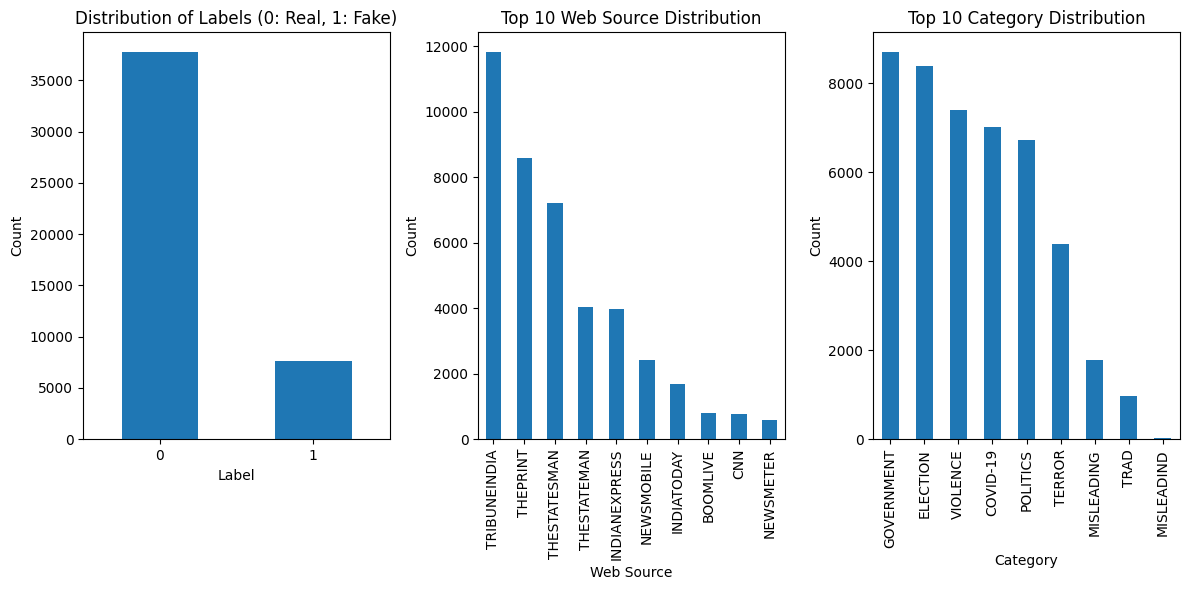

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot Label distribution
plt.subplot(1, 3, 1)
df['Label'].value_counts().plot(kind='bar')
plt.title('Distribution of Labels (0: Real, 1: Fake)')
plt.xlabel('Label')
plt.ylabel('Count')
plt.xticks(rotation=0)

# Plot top 10 Web sources distribution
plt.subplot(1, 3, 2)
df['Web'].value_counts().head(10).plot(kind='bar')
plt.title('Top 10 Web Source Distribution')
plt.xlabel('Web Source')
plt.ylabel('Count')
plt.xticks(rotation=90)

# Plot top 10 Category distribution
plt.subplot(1, 3, 3)
df['Category'].value_counts().head(10).plot(kind='bar')
plt.title('Top 10 Category Distribution')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

## Summary:

### Data Analysis Key Findings

* The dataset contains 45393 entries and 9 columns with no missing values.
* The numerical columns are 'id' and 'Label'. 'id' appears to be a unique identifier with a mean of approximately 22697 and a standard deviation of approximately 13106. 'Label' is a binary column.
* The 'Label' column shows a significant class imbalance, with 37800 entries labeled as 0 (presumably real news) and 7593 entries labeled as 1 (presumably fake news).
* The 'Web' column has a diverse set of sources, with 'TRIBUNEINDIA' being the most frequent, followed by 'THEPRINT' and 'THESTATESMAN'. Potential naming inconsistencies exist (e.g., 'THESTATESMAN'/'THESTATEMAN', 'THELOGICALINDIAN'/'THELOGICALINDIA').
* The most frequent categories in the 'Category' column are 'GOVERNMENT', 'ELECTION', 'VIOLENCE', and 'COVID-19'. A minor naming inconsistency was observed ('MISLEADING'/'MISLEADIND').

### Insights or Next Steps

* Address the class imbalance in the 'Label' column before model training to prevent the model from being biased towards the majority class.
* Investigate and potentially standardize the naming inconsistencies found in the 'Web' and 'Category' columns to ensure data consistency and accurate analysis.

In [12]:
# ✅ Train-Test Split
X = df['text_stop']
y = df['Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [13]:
# ✅ Logistic Regression
tfidf = TfidfVectorizer(max_features=20000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_tfidf, y_train)
y_pred = lr.predict(X_test_tfidf)
print('LR Accuracy:', accuracy_score(y_test, y_pred))

LR Accuracy: 0.9589161801960568


In [14]:
# ✅ SVM
svm = SVC(kernel='linear')
svm.fit(X_train_tfidf, y_train)
y_pred_svm = svm.predict(X_test_tfidf)
print('SVM F1:', f1_score(y_test, y_pred_svm))

SVM F1: 0.8832559800071403


In [15]:
# ✅ LSTM Deep Learning Model
tok = Tokenizer(num_words=40000)
tok.fit_on_texts(X_train)
X_train_seq = pad_sequences(tok.texts_to_sequences(X_train), maxlen=200)
X_test_seq = pad_sequences(tok.texts_to_sequences(X_test), maxlen=200)

model = Sequential([
    Embedding(40000, 128),
    LSTM(128, return_sequences=False),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train_seq, y_train, validation_split=0.2, epochs=3, batch_size=64)
pred = (model.predict(X_test_seq) > 0.5).astype(int)
print('LSTM Accuracy:', accuracy_score(y_test, pred))

Epoch 1/3
454/454 ━━━━━━━━━━━━━━━━━━━━ 211s 459ms/step - accuracy: 0.9006 - loss: 0.2653 - val_accuracy: 0.9676 - val_loss: 0.1014
Epoch 2/3
454/454 ━━━━━━━━━━━━━━━━━━━━ 266s 468ms/step - accuracy: 0.9733 - loss: 0.1030 - val_accuracy: 0.9643 - val_loss: 0.1153
Epoch 3/3
454/454 ━━━━━━━━━━━━━━━━━━━━ 209s 461ms/step - accuracy: 0.9889 - loss: 0.0362 - val_accuracy: 0.9624 - val_loss: 0.1258
284/284 ━━━━━━━━━━━━━━━━━━━━ 25s 89ms/step
LSTM Accuracy: 0.9640929617799318


In [16]:
# ✅ Comparative Analysis
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

print("--- Model Performance Comparison ---")

# Logistic Regression Metrics
print("\nLogistic Regression:")
print('Accuracy:', accuracy_score(y_test, y_pred))
print('F1 Score:', f1_score(y_test, y_pred))
print('Precision:', precision_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))

# SVM Metrics
print("\nSVM:")
print('Accuracy:', accuracy_score(y_test, y_pred_svm))
print('F1 Score:', f1_score(y_test, y_pred_svm))
print('Precision:', precision_score(y_test, y_pred_svm))
print('Recall:', recall_score(y_test, y_pred_svm))

# LSTM Metrics
print("\nLSTM:")
# The LSTM predictions are already calculated as 'pred' in the previous cell
print('Accuracy:', accuracy_score(y_test, pred))
print('F1 Score:', f1_score(y_test, pred))
print('Precision:', precision_score(y_test, pred))
print('Recall:', recall_score(y_test, pred))

print("\n--- Analysis Summary ---")
# Basic comparison based on a single metric (e.g., Accuracy)
if accuracy_score(y_test, y_pred) > accuracy_score(y_test, y_pred_svm) and accuracy_score(y_test, y_pred) > accuracy_score(y_test, pred):
    print("Logistic Regression has the highest accuracy.")
elif accuracy_score(y_test, y_pred_svm) > accuracy_score(y_test, y_pred) and accuracy_score(y_test, y_pred_svm) > accuracy_score(y_test, pred):
    print("SVM has the highest accuracy.")
else:
    print("LSTM has the highest accuracy.")

# You can add more detailed comparisons or visualizations as needed

--- Model Performance Comparison ---

Logistic Regression:
Accuracy: 0.9589161801960568
F1 Score: 0.8633198973983144
Precision: 0.9735537190082645
Recall: 0.7755102040816326

SVM:
Accuracy: 0.9639828174909131
F1 Score: 0.8832559800071403
Precision: 0.9648985959438378
Recall: 0.8143515470704411

LSTM:
Accuracy: 0.9640929617799318
F1 Score: 0.8885850991114149
Precision: 0.923951670220327
Recall: 0.8558262014483212

--- Analysis Summary ---
LSTM has the highest accuracy.


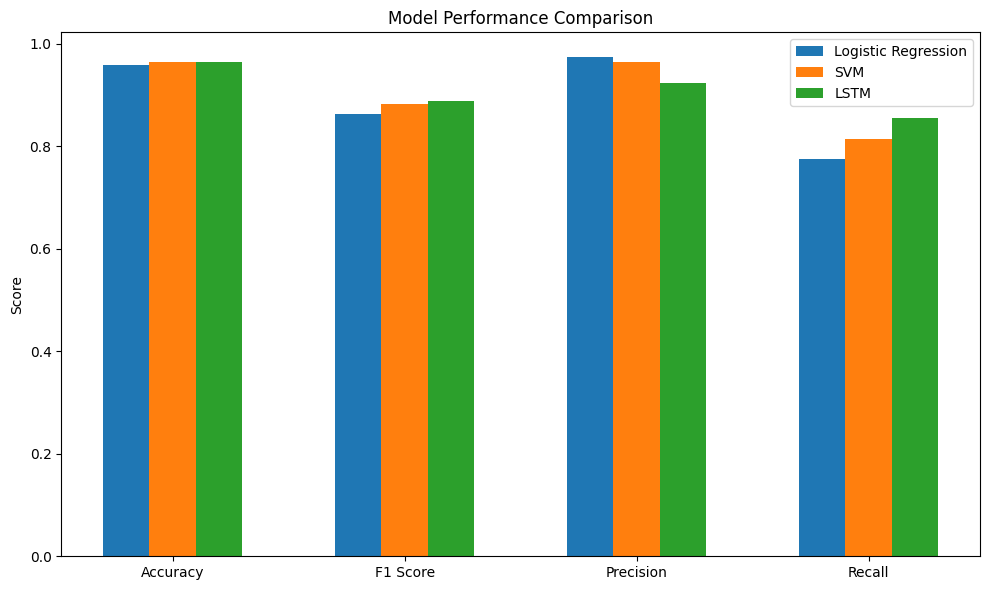

In [38]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming y_test, y_pred, y_pred_svm, and pred are available from previous cells

metrics = ['Accuracy', 'F1 Score', 'Precision', 'Recall']
lr_scores = [
    accuracy_score(y_test, y_pred),
    f1_score(y_test, y_pred),
    precision_score(y_test, y_pred),
    recall_score(y_test, y_pred)
]
svm_scores = [
    accuracy_score(y_test, y_pred_svm),
    f1_score(y_test, y_pred_svm),
    precision_score(y_test, y_pred_svm),
    recall_score(y_test, y_pred_svm)
]
lstm_scores = [
    accuracy_score(y_test, pred),
    f1_score(y_test, pred),
    precision_score(y_test, pred),
    recall_score(y_test, pred)
]

x = np.arange(len(metrics))
width = 0.2

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width, lr_scores, width, label='Logistic Regression')
rects2 = ax.bar(x, svm_scores, width, label='SVM')
rects3 = ax.bar(x + width, lstm_scores, width, label='LSTM')

ax.set_ylabel('Score')
ax.set_title('Model Performance Comparison')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

fig.tight_layout()

# Save the plot as an image file
plt.savefig('model_performance_comparison.png')

plt.show()

In [55]:
# ✅ Load Dataset
path = '/content/bharatfakenews.csv'  # change if needed
df.head()

,id,Author_Name,Fact_Check_Source,Source_Type,Statement,Eng_Trans_Statement,News Body,Eng_Trans_News_Body,Media_Link,Publish_Date,...,News_Category,Language,Region,Platform,Text,Video,Image,Label,text_clean,text_stop
0,BFNK_1,Shinjinee Majumder,Alt News,IFCN,à¥à¥à¤à¥à¤-à¤à¥à¤: à¤¤à¥à¤²à¤à¤à¤¾à...,Fact-check: A reporter in Telangana stopped sp...,à¤¸à¥à¤¶à¤² à¤®à¥à¤¡à¤¿à¤¯à¤¾ à¤ªà¤° à¤à¤ ...,A video is viral on social media in which a jo...,https://i0.wp.com/www.altnews.in/Hindi/wp-cont...,9th July 2022,...,Politics,Hindi,Telangana,Twitter,no,yes,no,0,fact check a reporter in telangana stopped spe...,fact check reporter telangana stopped speaking...
1,BFNK_2,Kalim Ahmed,Alt News,IFCN,PM à¤®à¥à¤¦à¥ à¤à¥ UAE à¤à¤¾ à¤¸à¤°à¥à¤µ...,Share by stating the old video of PM Modi's hi...,à¤ªà¥à¤°à¤§à¤¾à¤¨à¤®à¤à¤¤à¥à¤°à¥ à¤¨à¤°à¥...,A video of Prime Minister Narendra Modi being ...,https://i0.wp.com/www.altnews.in/Hindi/wp-cont...,9th July 2022,...,Politics,Hindi,National,Twitter,no,yes,no,0,share by stating the old video of pm modi s hi...,share stating old video pm modi highest civili...
2,BFNK_3,Abhishek Kumar,Alt News,IFCN,à¤µà¤¾à¤¯à¤°à¤² à¤¤à¤¸à¥à¤µà¥à¤° à¤®à¥à¤ à...,Supreme Court judges Suryakant and JB Pardiwal...,à¤¬à¥à¤¤à¥ à¤¦à¤¿à¤¨à¥à¤ à¤¨à¥à¤ªà¥à¤° à...,"Recently, Nupur Sharma made an objectionable c...",https://i0.wp.com/www.altnews.in/Hindi/wp-cont...,7th July 2022,...,Politics,Hindi,National,Twitter,no,no,yes,0,supreme court judges suryakant and jb pardiwal...,supreme court judges suryakant jb pardiwala vi...
3,BFNK_4,Abhishek Kumar,Alt News,IFCN,à¤®à¥à¤¡à¤¿à¤¯à¤¾ à¤¨à¥ à¤¦à¥ à¥à¤²à¤¤ à¥...,Media gave wrong news: After the victory of Mu...,à¤à¤ à¤µà¥à¤¡à¤¿à¤¯à¥ à¤¸à¥à¤¶à¤² à¤®à¥à...,A video is viral on social media. While sharin...,https://i0.wp.com/www.altnews.in/Hindi/wp-cont...,5th July 2022,...,Politics,Hindi,Madhya Pradesh,Twitter,no,no,yes,0,media gave wrong news after the victory of mus...,media gave wrong news victory muslim sarpanch ...
4,BFNK_5,Kinjal,Alt News,IFCN,à¤®à¤¹à¤¿à¤²à¤¾ à¤¨à¥ à¤°à¤¾à¤¹à¥à¤² à¤à¤¾à...,The woman lashed out at Rahul Gandhi to oppose...,à¤¸à¥à¤¶à¤² à¤®à¥à¤¡à¤¿à¤¯à¤¾ à¤ªà¤° à¤°à¤¾à...,A video of Rahul Gandhi has gone viral on soci...,https://i0.wp.com/www.altnews.in/Hindi/wp-cont...,4th July 2022,...,Politics,Hindi,Kashmir,Twitter,no,yes,no,1,the woman lashed out at rahul gandhi to oppose...,woman lashed rahul gandhi oppose modi governme...


In [56]:
# Cell 4 — Quick inspection: columns, missing, basic stats
# Comment: Observe available columns to find text & label columns. We'll attempt auto-detection below.
print("Columns:", df.columns.tolist())
print("\nMissing values per column:")
print(df.isna().sum().sort_values(ascending=False).head(20))
display(df.describe(include='all').T)


Columns: ['id', 'Author_Name', 'Fact_Check_Source', 'Source_Type', 'Statement', 'Eng_Trans_Statement', 'News Body', 'Eng_Trans_News_Body', 'Media_Link', 'Publish_Date', 'Fact_Check_Link', 'News_Category', 'Language', 'Region', 'Platform', 'Text', 'Video', 'Image', 'Label', 'text_clean', 'text_stop']

Missing values per column:
id                     0
Author_Name            0
Fact_Check_Source      0
Source_Type            0
Statement              0
Eng_Trans_Statement    0
News Body              0
Eng_Trans_News_Body    0
Media_Link             0
Publish_Date           0
Fact_Check_Link        0
News_Category          0
Language               0
Region                 0
Platform               0
Text                   0
Video                  0
Image                  0
Label                  0
text_clean             0
dtype: int64


,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,10486,10486,BFNK_10597,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Author_Name,10486,170,Yogesh Karia,1320,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fact_Check_Source,10486,8,Factcrescendo.com,5720,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Source_Type,10486,1,IFCN,10486,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Statement,10486,10486,à´à´ªàµà´ªà´¿à´¡àµà´¯àµà´±àµ½ à´ à´¨à´¾àµ½...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Eng_Trans_Statement,10486,10475,Is this ...?,5,NaN,NaN,NaN,NaN,NaN,NaN,NaN
News Body,10486,10430,à´ªàµà´°à´à´°à´¿à´àµà´àµà´¨àµà´¨ à´µà´¾...,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Eng_Trans_News_Body,10486,10428,India Today's Anti Fake News War Room (AFWA) f...,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Media_Link,10486,10429,https://static.thip.media/wp-content/uploads/2...,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Publish_Date,10486,4303,"July 5, 2022",19,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [59]:
# Cell 5 — Auto-detect text and label columns (robust heuristic)
# Comment: Common text columns: 'text','content','article','title','statement'; label columns: 'label','class','truth','verdict','target'
text_cols = [c for c in df.columns if any(k in c.lower() for k in ['text','content','article','title','statement','claim','body'])]
label_cols = [c for c in df.columns if any(k in c.lower() for k in ['label','class','target','verdict','truth','is_fake','category'])]

# Fallback heuristics if above fails
if not text_cols:
    # pick the longest string column as text
    object_cols = [c for c in df.columns if df[c].dtype == object]
    lengths = {c: df[c].dropna().astype(str).str.len().mean() for c in object_cols}
    if lengths:
        text_cols = [max(lengths, key=lengths.get)]

if not label_cols:
    # try columns with small unique counts
    for c in df.columns:
        if df[c].dtype != object and df[c].nunique() <= 5:
            label_cols.append(c)
    # or numeric columns with 0/1
    if not label_cols:
        for c in df.columns:
            uniq = sorted(df[c].dropna().unique().tolist())
            if set(uniq).issubset({0,1}):
                label_cols.append(c)

# Use first detected
text_col = text_cols[0] if text_cols else None
label_col = label_cols[0] if label_cols else None

print("Detected text column:", text_col)
print("Detected label column:", label_col)

# If detection failed, ask user to manually set
if text_col is None or label_col is None:
    raise ValueError("Could not auto-detect text or label column. Please set text_col and label_col manually. Columns found: " + str(df.columns.tolist()))

# Keep only text & label for now
data = df[[text_col, label_col]].rename(columns={text_col: 'text', label_col: 'label'}).dropna().reset_index(drop=True)
print("After dropping NA, shape:", data.shape)

# Comment: If your dataset uses nonstandard column names, edit DATA_PATH or set text_col/label_col manually.


Detected text column: Statement
Detected label column: News_Category
After dropping NA, shape: (10486, 2)


In [61]:
# Cell 5 — Auto-detect text and label columns (robust heuristic)
# Comment: Common text columns: 'text','content','article','title','statement'; label columns: 'label','class','truth','verdict','target'
text_cols = [c for c in df.columns if any(k in c.lower() for k in ['text','content','article','title','statement','claim','body'])]
label_cols = [c for c in df.columns if any(k in c.lower() for k in ['label','class','target','verdict','truth','is_fake','category'])]

# Fallback heuristics if above fails
if not text_cols:
    # pick the longest string column as text
    object_cols = [c for c in df.columns if df[c].dtype == object]
    lengths = {c: df[c].dropna().astype(str).str.len().mean() for c in object_cols}
    if lengths:
        text_cols = [max(lengths, key=lengths.get)]

if not label_cols:
    # try columns with small unique counts
    for c in df.columns:
        if df[c].dtype != object and df[c].nunique() <= 5:
            label_cols.append(c)
    # or numeric columns with 0/1
    if not label_cols:
        for c in df.columns:
            uniq = sorted(df[c].dropna().unique().tolist())
            if set(uniq).issubset({0,1}):
                label_cols.append(c)

# Use first detected
text_col = text_cols[0] if text_cols else None
label_col = 'Label' # Manually set label column to 'Label'

print("Detected text column:", text_col)
print("Detected label column:", label_col)

# If detection failed, ask user to manually set
if text_col is None or label_col is None:
    raise ValueError("Could not auto-detect text or label column. Please set text_col and label_col manually. Columns found: " + str(df.columns.tolist()))

# Keep only text & label for now
data = df[[text_col, label_col]].rename(columns={text_col: 'text', label_col: 'label'}).dropna().reset_index(drop=True)
print("After dropping NA, shape:", data.shape)

# The 'Label' column is already binary (0/1), so no normalization is needed here.
data['label_bin'] = data['label'].astype(int)

print("Label distribution (binary):")
print(data['label_bin'].value_counts())
# Comment: Check the label distribution to ensure mapping matches expected (1=Fake, 0=Real). If reversed, swap.

Detected text column: Statement
Detected label column: Label
After dropping NA, shape: (10486, 2)
Label distribution (binary):
label_bin
1    6338
0    4148
Name: count, dtype: int64


In [63]:
# Cell 7 — Basic text cleaning functions
# Comment: Clean HTML, urls, punctuation, multiple spaces and lowercase text.
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))

def clean_text(s):
    s = str(s)
    s = html.unescape(s)                # unescape HTML entities
    s = re.sub(r'http\S+', ' ', s)      # remove URLs
    s = re.sub(r'[^A-Za-z0-9\s]', ' ', s)  # remove punctuation
    s = re.sub(r'\s+', ' ', s).strip()  # collapse whitespace
    s = s.lower()
    return s

# Apply cleaning and compute simple features
data['text_clean'] = data['text'].apply(clean_text)
data['text_len'] = data['text_clean'].str.split().apply(len)
data['char_len'] = data['text_clean'].str.len()


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


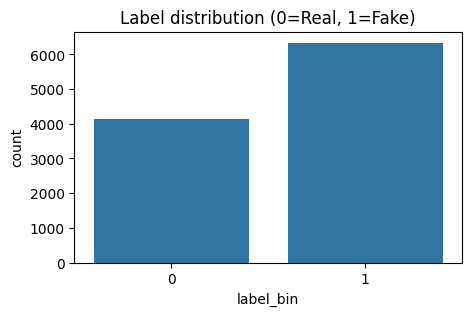

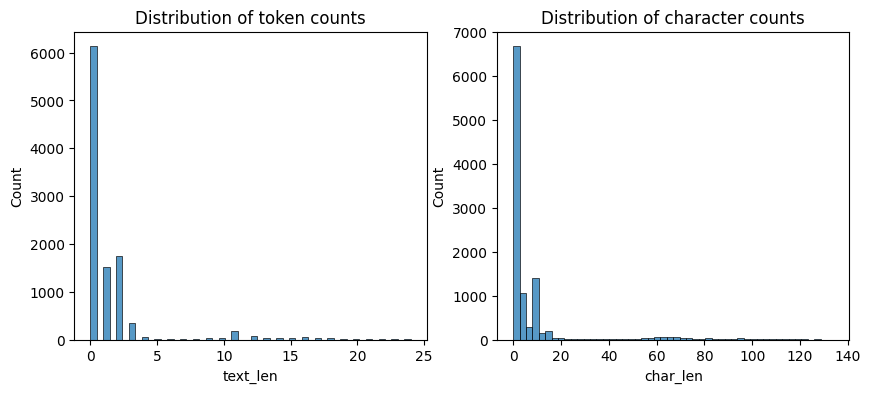

Top 30 words (no stopwords): [('fact', 2137), ('check', 2135), ('video', 193), ('bjp', 173), ('covid', 109), ('viral', 107), ('2019', 92), ('caa', 82), ('2018', 81), ('old', 77), ('shared', 71), ('rss', 61), ('2017', 58), ('falsely', 51), ('2020', 46), ('2015', 40), ('linked', 37), ('2016', 35), ('2014', 34), ('aap', 32), ('image', 31), ('vaccine', 31), ('jnu', 29), ('rapid', 28), ('nrc', 27), ('show', 27), ('people', 27), ('2000', 24), ('100', 23), ('nupur', 23)]


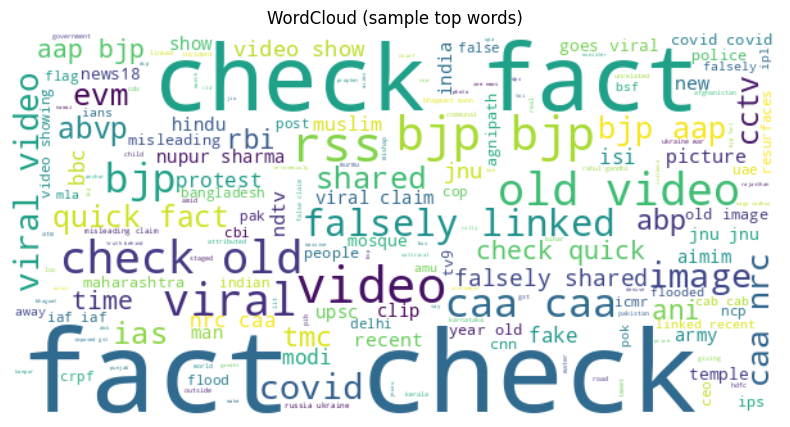

In [65]:
# Cell 8 — EDA: label balance, lengths, top words and wordcloud
# Comment: Visual checks to understand dataset balance and common vocabulary.
import matplotlib.pyplot as plt
import seaborn as sns # Import seaborn
from wordcloud import WordCloud
from collections import Counter # Import Counter

# Label distribution
plt.figure(figsize=(5,3))
sns.countplot(x='label_bin', data=data)
plt.title('Label distribution (0=Real, 1=Fake)')
plt.show()

# Length distributions
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
sns.histplot(data['text_len'], bins=50)
plt.title('Distribution of token counts')
plt.subplot(1,2,2)
sns.histplot(data['char_len'], bins=50)
plt.title('Distribution of character counts')
plt.show()

# Top words overall (excluding stopwords)
all_words = ' '.join(data['text_clean'].tolist()).split()
filtered = [w for w in all_words if w not in STOPWORDS and len(w)>2]
top_words = Counter(filtered).most_common(30)
print("Top 30 words (no stopwords):", top_words[:30])

# WordCloud for fake vs real (optional)
fake_text = ' '.join(data.loc[data['label_bin']==1,'text_clean'].tolist())
real_text = ' '.join(data.loc[data['label_bin']==0,'text_clean'].tolist())

wc = WordCloud(width=600, height=300, background_color='white').generate(' '.join(filtered[:5000]))
plt.figure(figsize=(10,5))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('WordCloud (sample top words)')
plt.show()

# Comment: Word clouds and common n-grams help identify topics common to fake vs real articles.

In [66]:
# Cell 9 — EDA: top n-grams per class (bigrams)
# Comment: Show the most frequent bigrams in fake and real texts to see pattern differences.
from sklearn.feature_extraction.text import CountVectorizer

def top_ngrams(corpus, n=None, ngram_range=(1,1)):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words='english', max_features=5000)
    X = vec.fit_transform(corpus)
    sums = np.array(X.sum(axis=0)).ravel()
    items = [(word, sums[idx]) for word, idx in vec.vocabulary_.items()]
    items_sorted = sorted(items, key=lambda x: x[1], reverse=True)
    return items_sorted[:n]

print("Top 15 bigrams in Fake:")
print(top_ngrams(data.loc[data['label_bin']==1,'text_clean'], n=15, ngram_range=(2,2)))
print("\nTop 15 bigrams in Real:")
print(top_ngrams(data.loc[data['label_bin']==0,'text_clean'], n=15, ngram_range=(2,2)))

# Comment: Differences in bigram frequencies often reveal distinguishing phrases.


Top 15 bigrams in Fake:
[('fact check', np.int64(1221)), ('old video', np.int64(38)), ('check old', np.int64(35)), ('covid 19', np.int64(33)), ('check video', np.int64(25)), ('falsely linked', np.int64(20)), ('check did', np.int64(20)), ('check viral', np.int64(17)), ('viral video', np.int64(17)), ('check does', np.int64(16)), ('rapid fc', np.int64(15)), ('nupur sharma', np.int64(14)), ('falsely shared', np.int64(13)), ('goes viral', np.int64(12)), ('quick fact', np.int64(10))]

Top 15 bigrams in Real:
[('fact check', np.int64(914)), ('covid 19', np.int64(40)), ('check did', np.int64(29)), ('check does', np.int64(24)), ('check covid', np.int64(19)), ('old video', np.int64(15)), ('check video', np.int64(14)), ('caa nrc', np.int64(12)), ('covid vaccine', np.int64(12)), ('viral video', np.int64(10)), ('19 vaccines', np.int64(10)), ('check old', np.int64(9)), ('check viral', np.int64(9)), ('falsely linked', np.int64(7)), ('check 2019', np.int64(7))]


In [68]:
# Cell 10 — Train/test split
# Comment: We'll use stratified split to maintain label balance between train and test sets.
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42 # Define RANDOM_SEED

X = data['text_clean']
y = data['label_bin']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, stratify=y, random_state=RANDOM_SEED)
print("Train/Test sizes:", X_train.shape, X_test.shape)
# Comment: Stratified split helps when classes are imbalanced.

Train/Test sizes: (8388,) (2098,)


In [69]:
# Cell 11 — Feature extraction for classical models: TF-IDF
# Comment: Fit TF-IDF on training texts and transform both train and test.
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=40000, ngram_range=(1,2), stop_words='english')
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

print("TF-IDF shape (train):", X_train_tfidf.shape)
# Save vectorizer for later reuse if needed
import joblib
joblib.dump(tfidf, 'tfidf_vectorizer.joblib')
# Comment: We limit vocabulary to 40k features (adjust depending on dataset size).


TF-IDF shape (train): (8388, 5916)


['tfidf_vectorizer.joblib']

=== Logistic Regression ===
Accuracy: 0.5915157292659676
Precision: 0.6303107165504122
Recall: 0.7839116719242902
F1: 0.6987697715289982

Classification report:
               precision    recall  f1-score   support

           0       0.47      0.30      0.37       830
           1       0.63      0.78      0.70      1268

    accuracy                           0.59      2098
   macro avg       0.55      0.54      0.53      2098
weighted avg       0.57      0.59      0.57      2098



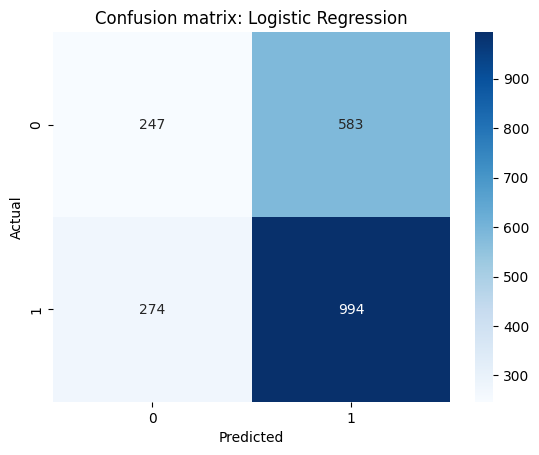

In [70]:
# Cell 12 — Model 1: Logistic Regression training & evaluation
# Comment: Train with balanced class weight to mitigate imbalance. Evaluate using common metrics.
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

lr = LogisticRegression(max_iter=2000, class_weight='balanced', random_state=RANDOM_SEED)
lr.fit(X_train_tfidf, y_train)
y_pred_lr = lr.predict(X_test_tfidf)

def print_metrics(y_true, y_pred, label='Model'):
    print(f"=== {label} ===")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Precision:", precision_score(y_true, y_pred, zero_division=0))
    print("Recall:", recall_score(y_true, y_pred, zero_division=0))
    print("F1:", f1_score(y_true, y_pred, zero_division=0))
    print("\nClassification report:\n", classification_report(y_true, y_pred, zero_division=0))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion matrix: {label}')
    plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.show()

print_metrics(y_test, y_pred_lr, 'Logistic Regression')
# Comment: class_weight='balanced' helps account for class imbalance.


=== Linear SVM (calibrated) ===
Accuracy: 0.6048617731172545
Precision: 0.6053768602976476
Recall: 0.9944794952681388
F1: 0.7526111608475082

Classification report:
               precision    recall  f1-score   support

           0       0.53      0.01      0.02       830
           1       0.61      0.99      0.75      1268

    accuracy                           0.60      2098
   macro avg       0.57      0.50      0.39      2098
weighted avg       0.58      0.60      0.46      2098



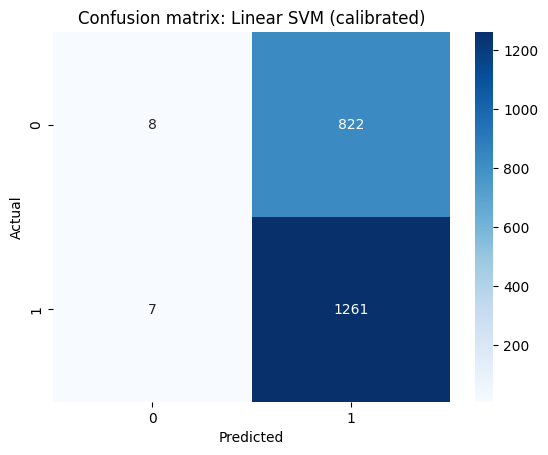

In [71]:
# Cell 13 — Model 2: Support Vector Machine (Linear SVM) training & evaluation
# Comment: Use LinearSVC or SVC with linear kernel. We use SVC(probability=False) may be slower; here we use LinearSVC for speed.
from sklearn.svm import LinearSVC
from sklearn.calibration import CalibratedClassifierCV

# LinearSVC does not give probabilities; we can wrap it with calibration if needed.
svc = LinearSVC(class_weight='balanced', random_state=RANDOM_SEED, max_iter=5000)
svc.fit(X_train_tfidf, y_train)
# Optionally calibrate for probabilities (not necessary for classification metrics)
calibrated_svc = CalibratedClassifierCV(svc)  # this will be slower
calibrated_svc.fit(X_train_tfidf, y_train)

y_pred_svc = calibrated_svc.predict(X_test_tfidf)
print_metrics(y_test, y_pred_svc, 'Linear SVM (calibrated)')
# Comment: SVMs often perform well on text; calibration provides probabilities if needed.


In [72]:
# Cell 14 — Prepare sequences for LSTM (deep learning)
# Comment: Tokenize text, convert to padded sequences, then build a simple LSTM model.
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

MAX_WORDS = 30000   # vocabulary size for tokenizer (adjustable)
MAX_LEN = 200       # sequence length (adjustable)
tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq  = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post', truncating='post')
X_test_pad  = pad_sequences(X_test_seq,  maxlen=MAX_LEN, padding='post', truncating='post')

print("Seq shapes:", X_train_pad.shape, X_test_pad.shape)
# Save tokenizer
joblib.dump(tokenizer, 'tokenizer.joblib')
# Comment: MAX_LEN=200 is usually fine for news; increase if texts are very long.


Seq shapes: (8388, 200) (2098, 200)


['tokenizer.joblib']

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Class weights: {0: np.float64(1.2640144665461122), 1: np.float64(0.8272189349112427)}
Epoch 1/6
59/59 ━━━━━━━━━━━━━━━━━━━━ 83s 1s/step - accuracy: 0.4913 - loss: 0.6941 - val_accuracy: 0.6126 - val_loss: 0.6860
Epoch 2/6
59/59 ━━━━━━━━━━━━━━━━━━━━ 70s 1s/step - accuracy: 0.5134 - loss: 0.6939 - val_accuracy: 0.6055 - val_loss: 0.6838
Epoch 3/6
59/59 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.5620 - loss: 0.6935 - val_accuracy: 0.5900 - val_loss: 0.6878
Epoch 4/6
59/59 ━━━━━━━━━━━━━━━━━━━━ 72s 1s/step - accuracy: 0.5863 - loss: 0.6798 - val_accuracy: 0.6174 - val_loss: 0.6949
Epoch 4: early stopping
Restoring model weights from the end of the best epoch: 2.
9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 682ms/step
=== LSTM ===
Accuracy: 0.6053384175405148
Precision: 0.6096709870388833
Recall: 0.9645110410094637
F1: 0.7470983506414173

Classification report:
               precision    recall  f1-score   support

           0       0.51      0.06      0.10       830
           1       0.61      0.96   

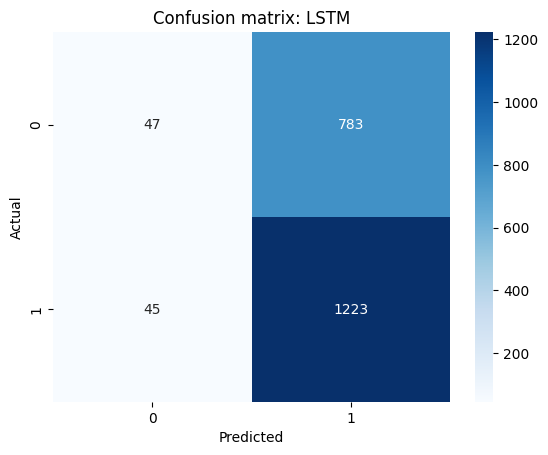

In [73]:
# Cell 15 — LSTM model definition, training and evaluation
# Comment: Basic LSTM with embedding. Use EarlyStopping for faster convergence.
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping

EMBED_DIM = 100

model = Sequential([
    Embedding(input_dim=MAX_WORDS, output_dim=EMBED_DIM, input_length=MAX_LEN),
    Bidirectional(LSTM(128, return_sequences=False)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()

# Class weights to handle imbalance (optional)
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}
print("Class weights:", class_weight_dict)

es = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True, verbose=1)
history = model.fit(X_train_pad, y_train, validation_split=0.1, epochs=6, batch_size=128,
                    class_weight=class_weight_dict, callbacks=[es])

# Evaluate on test set
y_pred_prob_lstm = model.predict(X_test_pad, batch_size=256).ravel()
y_pred_lstm = (y_pred_prob_lstm >= 0.5).astype(int)

print_metrics(y_test, y_pred_lstm, 'LSTM')
# Comment: LSTM training can be slow on CPU; consider using GPU runtime in Colab for speed.


In [74]:
# Cell 16 — Compare the three models in a table
# Comment: Collate the main metrics for easy comparison.
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

models_summary = []

# LR
models_summary.append({
    'model': 'Logistic Regression',
    'accuracy': accuracy_score(y_test, y_pred_lr),
    'precision': precision_score(y_test, y_pred_lr, zero_division=0),
    'recall': recall_score(y_test, y_pred_lr, zero_division=0),
    'f1': f1_score(y_test, y_pred_lr, zero_division=0)
})

# SVM
models_summary.append({
    'model': 'Linear SVM',
    'accuracy': accuracy_score(y_test, y_pred_svc),
    'precision': precision_score(y_test, y_pred_svc, zero_division=0),
    'recall': recall_score(y_test, y_pred_svc, zero_division=0),
    'f1': f1_score(y_test, y_pred_svc, zero_division=0)
})

# LSTM
models_summary.append({
    'model': 'LSTM',
    'accuracy': accuracy_score(y_test, y_pred_lstm),
    'precision': precision_score(y_test, y_pred_lstm, zero_division=0),
    'recall': recall_score(y_test, y_pred_lstm, zero_division=0),
    'f1': f1_score(y_test, y_pred_lstm, zero_division=0)
})

summary_df = pd.DataFrame(models_summary).sort_values(by='f1', ascending=False).reset_index(drop=True)
display(summary_df)

# Comment: Use this table in your report to compare model performance. F1 is often most informative for imbalanced classes.


,model,accuracy,precision,recall,f1
0,Linear SVM,0.604862,0.605377,0.994479,0.752611
1,LSTM,0.605338,0.609671,0.964511,0.747098
2,Logistic Regression,0.591516,0.630311,0.783912,0.698770


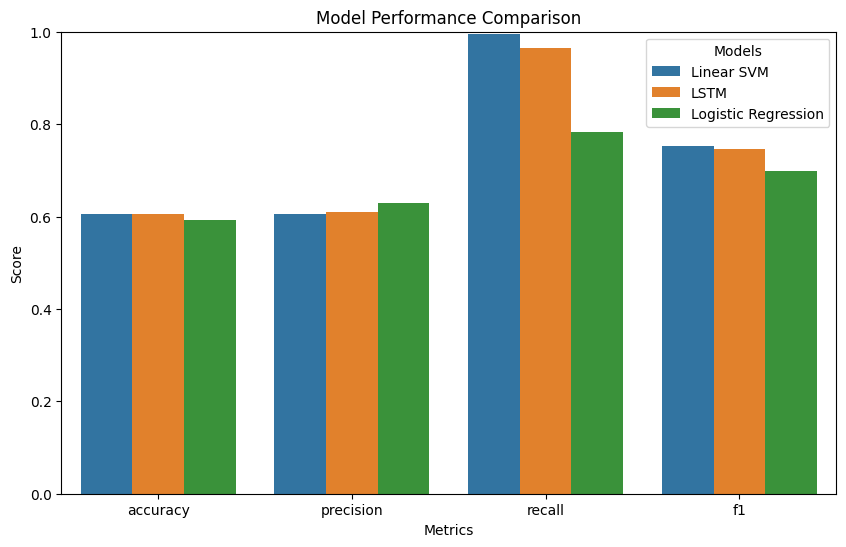

In [75]:
# Bar chart to compare model metrics
metrics = ['accuracy', 'precision', 'recall', 'f1']
summary_melted = summary_df.melt(id_vars='model', value_vars=metrics, var_name='metric', value_name='score')

plt.figure(figsize=(10,6))
sns.barplot(x='metric', y='score', hue='model', data=summary_melted)
plt.title('Model Performance Comparison')
plt.ylabel('Score')
plt.xlabel('Metrics')
plt.ylim(0, 1)
plt.legend(title='Models')
plt.show()


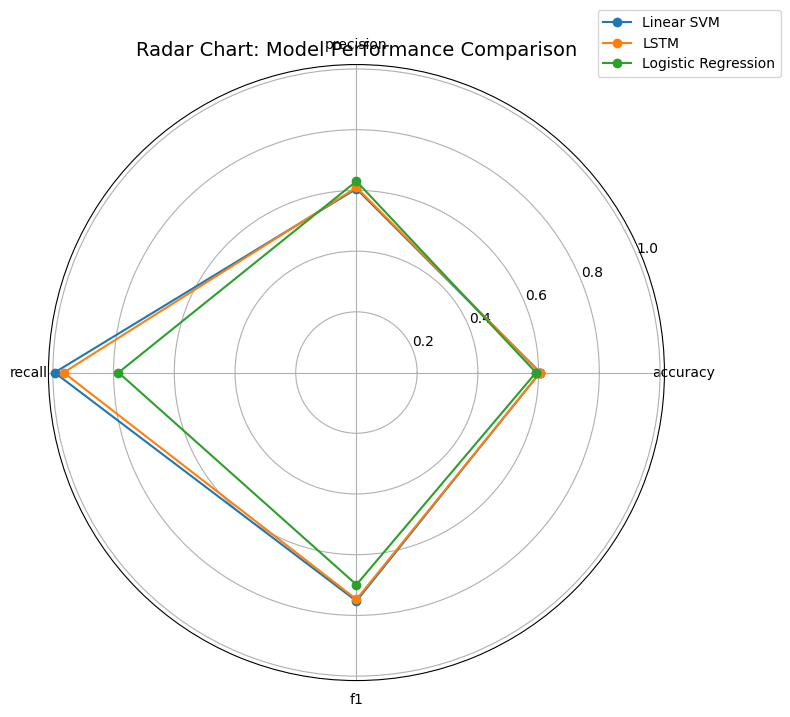

In [76]:
# Radar chart for model performance comparison
import numpy as np

labels = metrics
num_vars = len(labels)

angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]

plt.figure(figsize=(8,8))

for i, row in summary_df.iterrows():
    values = row[metrics].tolist()
    values += values[:1]
    plt.polar(angles, values, marker='o', label=row['model'])

plt.xticks(angles[:-1], labels)
plt.title("Radar Chart: Model Performance Comparison", size=14)
plt.legend(loc='upper right', bbox_to_anchor=(1.2, 1.1))
plt.show()
